In [937]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PWD = Path.cwd()

In [938]:
df = pd.read_csv(
    f'{PWD}/LLM+Planning+Evaluation_8+October+2024_01.15.tsv',
    sep='\t',
    encoding='utf-16',
)

questions = pd.read_json('../surveys/final.jsonl', lines=True)

datasets = questions['dataset'].unique()
models = questions['model'].unique()
dataset_model_combinations = [(d, m) for d in datasets for m in models]

POINT_SCALE = 5


def t2i(
    text: str,
    point_scale: int = 5,
) -> int:
    if point_scale == 5:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 2,
            'Neither agree nor disagree': 3,
            'Somewhat agree': 4,
            'Strongly agree': 5,
        }
    elif point_scale == 3:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 1,
            'Neither agree nor disagree': 2,
            'Somewhat agree': 3,
            'Strongly agree': 3,
        }

    return mapping.get(text, None)


def i2t(
    integer: int,
    point_scale: int = 5,
) -> str:
    integer = int(integer)
    if point_scale == 5:
        mapping = {
            1: 'SD',
            2: 'sD',
            3: 'N',
            4: 'sA',
            5: 'SA',
        }
    elif point_scale == 3:
        mapping = {
            1: 'SD',
            2: 'N',
            3: 'SA',
        }

    return mapping.get(integer, None)

/tmp/ipykernel_20422/2340921146.py:1: DtypeWarning: Columns (4,5,6,9,10,11,12,13,14,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,179,180,181,182,183,184,185,186,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,2

In [939]:
datasets, models

(array(['Franklin', 'GSM8k', 'HotpotQA', 'StrategyQA'], dtype=object),
 array(['google/gemma-2-9b-it', 'meta-llama/Meta-Llama-3.1-8B-Instruct',
        'microsoft/Phi-3.5-mini-instruct', 'openai/gpt-4o-mini'],
       dtype=object))

In [940]:
questions.head()

,uuid,is_attention_check,dataset,model,question,parsed_response,html
0,36b1a3da-bc2b-4a9f-b0b5-31887af03c91,False,Franklin,google/gemma-2-9b-it,Which country will have the lower energy consu...,## Step-by-Step Plan:\n\n1. **Identify Data So...,<p><em>Which country will have the lower energ...
1,424e96e0-5051-426d-9d57-0ccc5fa352db,False,Franklin,google/gemma-2-9b-it,Which country in Northern Europe had the highe...,Here is the plan:\n\n1. **Define Northern Euro...,<p><em>Which country in Northern Europe had th...
2,c4b1e32f-1886-440a-9f9f-66a4d71eabdb,False,Franklin,google/gemma-2-9b-it,Which country in Eastern Asia had the highest ...,"## Plan:\n\n1. **Define ""Eastern Asia"":** Cons...",<p><em>Which country in Eastern Asia had the h...
3,b8d5fa16-e8fa-459c-93f7-3edc6b82b152,False,Franklin,google/gemma-2-9b-it,For the country in Micronesia that had the low...,## Plan:\n\n1. **Identify the country in Micro...,<p><em>For the country in Micronesia that had ...
4,5d5b6078-7e8e-4511-862b-3f2ecbccf019,False,Franklin,google/gemma-2-9b-it,Which country will have the higher life expect...,Here is the plan:\n\n1. **Identify reliable so...,<p><em>Which country will have the higher life...


In [941]:
# set column name to item in row 0
df.columns = df.iloc[0]
# save the 'original dataframe' to a new variable
original_columns = deepcopy(df)
# drop row 0
df = df.drop(0)
# set index to 'PROLIFIC_PID'
df = df.set_index('PROLIFIC_PID')

In [942]:
# get durations and remove outliers
durations = df['Duration (in seconds)'].astype(float).map(lambda x: x / 60)
# print some stats about duration
print(durations.describe())

count    257.000000
mean      23.973930
std       12.246549
min        3.650000
25%       15.533333
50%       21.300000
75%       29.983333
max       72.483333
Name: Duration (in seconds), dtype: float64


In [943]:
# get durations which are more than 3 standard deviations lower than the mean
outliers_time = durations.mean() - 3 * durations.std()
print(f'Minimum permissible time: {outliers_time} minutes')
outliers = durations[durations < outliers_time]
print(outliers)
# remove outliers
df = df[~df.index.isin(outliers.index)]

Minimum permissible time: -12.765717973771746 minutes
Series([], Name: Duration (in seconds), dtype: float64)


In [944]:
# find the uuid in the string using regex to match a 36 character string
df.columns = df.columns.str.extract(r'([a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}_[1-4])')[0]
# only return columns where there is a match
df = df[df.columns.dropna()]
# drop columns with all NaN values
df = df.dropna(axis=1, how='all')

In [945]:
attention_checks_uuid = 'd67998d7-8f14-4f50-823b-cb63027f21d9'
attention_check_cols = [col for col in df.columns if col.startswith(attention_checks_uuid)]
df = df.drop(attention_check_cols, axis=1)
attention_check_somewhat_agree_uuid = 'd67998d7-8f14-4f50-823b-cb63027f21d9_4 - Where'
attention_check_strongly_disagree_uuid = 'd67998d7-8f14-4f50-823b-cb63027f21d9_3 - Could'
# get columns in original df which start with either of the two attention check uuids
valid_columns = original_columns.columns[
    original_columns.columns.str.startswith(attention_check_somewhat_agree_uuid)
    | original_columns.columns.str.startswith(attention_check_strongly_disagree_uuid)
]
attention_check_df = original_columns[valid_columns]
attention_check_df = attention_check_df.drop(0)
# rename columns
attention_check_df.columns = [4, 1]
attention_check_df = attention_check_df.map(t2i)
print(attention_check_df)

     4  1
1    4  1
2    4  1
3    4  1
4    4  1
5    4  2
..  .. ..
253  4  1
254  4  1
255  4  2
256  4  1
257  4  1

[257 rows x 2 columns]


Attention checks

In [946]:
# # get rows where cell does not match column name for both columns
# attention_check_df = attention_check_df[
#     (attention_check_df['Somewhat agree'] != 'Somewhat agree')
#     | (attention_check_df['Strongly disagree'] != 'Strongly disagree')
# ]
attention_check_df = attention_check_df[(attention_check_df[4] != 4) | (attention_check_df[1] != 1)]

In [947]:
attention_check_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 5 to 255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   4       31 non-null     int64
 1   1       31 non-null     int64
dtypes: int64(2)
memory usage: 744.0 bytes


In [948]:
print(f'Failed attention checks: {len(attention_check_df)}/{len(df)} ({len(attention_check_df) / len(df) * 100:.2f}%)')
# remove rows where attention check failed
df = df[~df.index.isin(attention_check_df.index)]
print(attention_check_df.index)

Failed attention checks: 31/257 (12.06%)
Index([  5,  14,  25,  29,  35,  37,  45,  48,  59,  63,  66,  72,  73,  77,
        89, 106, 126, 127, 129, 132, 136, 144, 149, 150, 170, 211, 225, 230,
       231, 244, 255],
      dtype='int64')


In [949]:
# get rows where all non-NaN values are the same
rows = df.apply(lambda x: len(set(x.dropna())) == 1, axis=1)
# print rows where value is true and not false
rows = rows[rows == True]
print(f'Rows with same values: {len(rows)} ({len(rows) / len(df) * 100:.2f}%)')
# drop these rows from the dataframe
df = df.drop(rows.index)

Rows with same values: 0 (0.00%)


In [950]:
"""
Split main dataframe into 3 dataframes for each variation of the question.
Split also by dataset and model.
"""
df = df.map(t2i)
# get uuids in survey
uuids_in_survey = {i.split('_')[0] for i in df.columns}
# get questions where questions['uuid'] is in uuids_in_survey
questions = questions[questions['uuid'].isin(uuids_in_survey)]
# # many-to-one mapping between ('model', 'dataset') and 'uuid'. get uuids for each ('model', 'dataset') pair
grouped_uuids = questions.groupby(['dataset', 'model'])['uuid'].apply(list).to_dict()
# # each uuid contains 3 variations with suffixes _1, _2, _3. create separate dataframes for each variation
sat, answered, planned, executed = {}, {}, {}, {}
for (dataset, model), uuids in grouped_uuids.items():
    sat[(dataset, model)] = df[[f'{uuid}_1' for uuid in uuids]].apply(pd.to_numeric)
    answered[(dataset, model)] = df[[f'{uuid}_2' for uuid in uuids]].apply(pd.to_numeric)
    planned[(dataset, model)] = df[[f'{uuid}_3' for uuid in uuids]].apply(pd.to_numeric)
    executed[(dataset, model)] = df[[f'{uuid}_4' for uuid in uuids]].apply(pd.to_numeric)

all_sat = pd.concat([sat[(dataset, model)] for dataset, model in grouped_uuids])
all_answered = pd.concat([answered[(dataset, model)] for dataset, model in grouped_uuids])
all_planned = pd.concat([planned[(dataset, model)] for dataset, model in grouped_uuids])
all_executed = pd.concat([executed[(dataset, model)] for dataset, model in grouped_uuids])

In [951]:
sat_mean_std = []
answered_mean_std = []
planned_mean_std = []
executed_mean_std = []

for dataset, model in grouped_uuids:
    sat_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [sat[(dataset, model)].std().mean()],
        }
    )
    answered_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [answered[(dataset, model)].std().mean()],
        }
    )
    planned_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [planned[(dataset, model)].std().mean()],
        }
    )
    executed_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [executed[(dataset, model)].std().mean()],
        }
    )

sat[('Franklin', 'openai/gpt-4o-mini')]

,0869444c-aa4b-492a-8a13-985f6d6720b5_1,d72fa515-c0f1-41ae-a792-a96409c69308_1,0376540a-e2f3-4245-8f06-2ac14a692010_1,cdf1283c-f705-45c4-af93-3cd42956dec6_1,5eeb2ad1-df04-4feb-b414-9746cc99f78c_1,0be5ff45-2379-4bfd-81ee-7d2eb41ae7a1_1,e1681ec9-220e-401a-b534-920319d8d157_1,43dd9c34-ef32-4a0f-85f0-8e07ad354dd0_1,65762c75-e21d-49dd-bbbb-77a368b1b5d2_1,32b1f7dc-db5a-404f-babd-b0b93b77eabb_1,...,05421006-2567-4b5a-b278-707508b7437b_1,3dd60711-96de-4923-a71b-edce7031651b_1,26c6302a-481f-4a76-96d9-68ad30a9ca58_1,c8a7f9ce-ff34-4264-922c-88103360c995_1,191ffea9-0384-488e-bdbf-6df846059869_1,27717108-e566-4026-b387-b2e0bdbde84b_1,950b7187-5588-4b0f-a1e1-cdacd1ba3150_1,2fea27be-9ba3-45b2-8288-1213039568be_1,7b419f29-8cc7-4c1d-8bd9-c273b4dd1182_1,58bb25a0-f690-41e9-a781-a92f315d9da4_1
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
5ebd30bca8d08203a6e2334f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66f88d8c5fa10159db0db5c8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f4cbdf9f599118d27c21442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669129db4e9424079e8fb66b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6648c2b185cc799f4856c1b4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6644b2aa02acf5d3b7fc8188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66a18abd1f0ca227f65962bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6435816b3f5be1197802bcd5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [952]:
def remove_outliers(
    df_dict: dict[tuple, pd.DataFrame],
) -> dict[tuple, pd.DataFrame]:
    """Remove outliers from a dataframe using the IQR method.

    Parameters
    ----------
    df_dict : dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model.

    Returns
    -------
    dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model with outliers removed.

    """

    def get_outliers(df):
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1

        outlier_columns = df[(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))]

        return outlier_columns

    outliers = {}
    outliers_removed = {}

    for (dataset, model), df in df_dict.items():
        outliers_df = get_outliers(df)
        outliers_removed[(dataset, model)] = df[~outliers_df.notna().any(axis=1)]
        outliers[(dataset, model)] = outliers_df
        # percentage of outliers for a given dataset and model
        # outlier_info.append(
        #     {
        #         'dataset': dataset,
        #         'model': model,
        #         'percentage': outliers.count().sum() / df.shape
        #     }
        # )

    return outliers_removed, outliers


# ask, ask_outliers = remove_outliers(ask)
# plan, plan_outliers = remove_outliers(plan)
# sat, sat_outliers = remove_outliers(sat)

In [953]:
def majority_vote(df_dict: dict[tuple, pd.DataFrame]) -> pd.DataFrame:
    """Majority vote for a dataframe.

    Parameters
    ----------
    df_dict : dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model.

    Returns
    -------
    pd.DataFrame
        A dataframe containing the majority vote for each dataset and model.

    """
    for (dataset, model), df in df_dict.items():
        # for each column in df
        for column in df.columns:
            # get the most common value(s) in the column, averaging if there are multiple
            most_common = df[column].mode().mean()
            # set all values in the column to the most common value
            df[column] = most_common

        df_dict[(dataset, model)] = df

    return df_dict


# ask = majority_vote(ask)
# plan = majority_vote(plan)
# sat = majority_vote(sat)

In [954]:
dataset = 'Franklin'
# dataset = 'GSM8k'
# dataset = 'HotpotQA'
# dataset = 'StrategyQA'
# model = 'google/gemma-2-9b-it'
# model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model = 'microsoft/Phi-3.5-mini-instruct'
# model = 'openai/gpt-4o-mini'

In [955]:
def compute_column_sem(dataframe: pd.DataFrame) -> pd.Series:
    # Remove NaN values and compute SEM for each column
    df = [col[~np.isnan(col)] for col in dataframe.to_numpy().T]
    sem = pd.Series([pd.Series(col).sem() for col in df])
    return sem


def compute_average_sem(df_dict: dict[tuple, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for (dataset, model), dataframe in df_dict.items():
        sem = compute_column_sem(dataframe)
        sem_mean = sem.mean()
        # Get mean value for all columns
        mean = pd.Series([pd.Series(col).mean() for col in dataframe.to_numpy().T]).mean()
        # Get std value for all columns
        std = pd.Series([pd.Series(col).std() for col in dataframe.to_numpy().T]).mean()

        rows.append(
            {
                'dataset': dataset,
                'model': model,
                'mean': mean,
                'std': std,
                'sem-mean': sem_mean,
            }
        )

    # Convert to DataFrame and round floats to 2 decimal places
    df = pd.DataFrame(rows).round(2)
    return df


# Example usage
sems = compute_average_sem(sat)
print(sems)

       dataset                                  model  mean   std  sem-mean
0     Franklin                   google/gemma-2-9b-it  4.45  0.63      0.31
1     Franklin  meta-llama/Meta-Llama-3.1-8B-Instruct  4.53  0.67      0.33
2     Franklin        microsoft/Phi-3.5-mini-instruct  4.43  0.73      0.36
3     Franklin                     openai/gpt-4o-mini  3.92  1.15      0.58
4        GSM8k                   google/gemma-2-9b-it  4.26  0.85      0.42
5        GSM8k  meta-llama/Meta-Llama-3.1-8B-Instruct  4.62  0.53      0.26
6        GSM8k        microsoft/Phi-3.5-mini-instruct  4.57  0.61      0.31
7        GSM8k                     openai/gpt-4o-mini  4.47  0.74      0.37
8     HotpotQA                   google/gemma-2-9b-it  4.08  0.92      0.46
9     HotpotQA  meta-llama/Meta-Llama-3.1-8B-Instruct  4.36  0.71      0.35
10    HotpotQA        microsoft/Phi-3.5-mini-instruct  4.39  0.73      0.37
11    HotpotQA                     openai/gpt-4o-mini  3.98  1.05      0.52
12  Strategy

       dataset                                  model   average       std  \
0     Franklin                   google/gemma-2-9b-it  4.451362  0.836060   
1     Franklin  meta-llama/Meta-Llama-3.1-8B-Instruct  4.521401  0.904232   
2     Franklin        microsoft/Phi-3.5-mini-instruct  4.424125  0.914157   
3     Franklin                     openai/gpt-4o-mini  3.922179  1.235726   
4        GSM8k                   google/gemma-2-9b-it  4.260700  1.159520   
5        GSM8k  meta-llama/Meta-Llama-3.1-8B-Instruct  4.614786  0.805776   
6        GSM8k        microsoft/Phi-3.5-mini-instruct  4.560311  0.746757   
7        GSM8k                     openai/gpt-4o-mini  4.463035  0.890719   
8     HotpotQA                   google/gemma-2-9b-it  4.085603  1.173834   
9     HotpotQA  meta-llama/Meta-Llama-3.1-8B-Instruct  4.354086  1.011179   
10    HotpotQA        microsoft/Phi-3.5-mini-instruct  4.385214  0.910090   
11    HotpotQA                     openai/gpt-4o-mini  3.961089  1.256285   

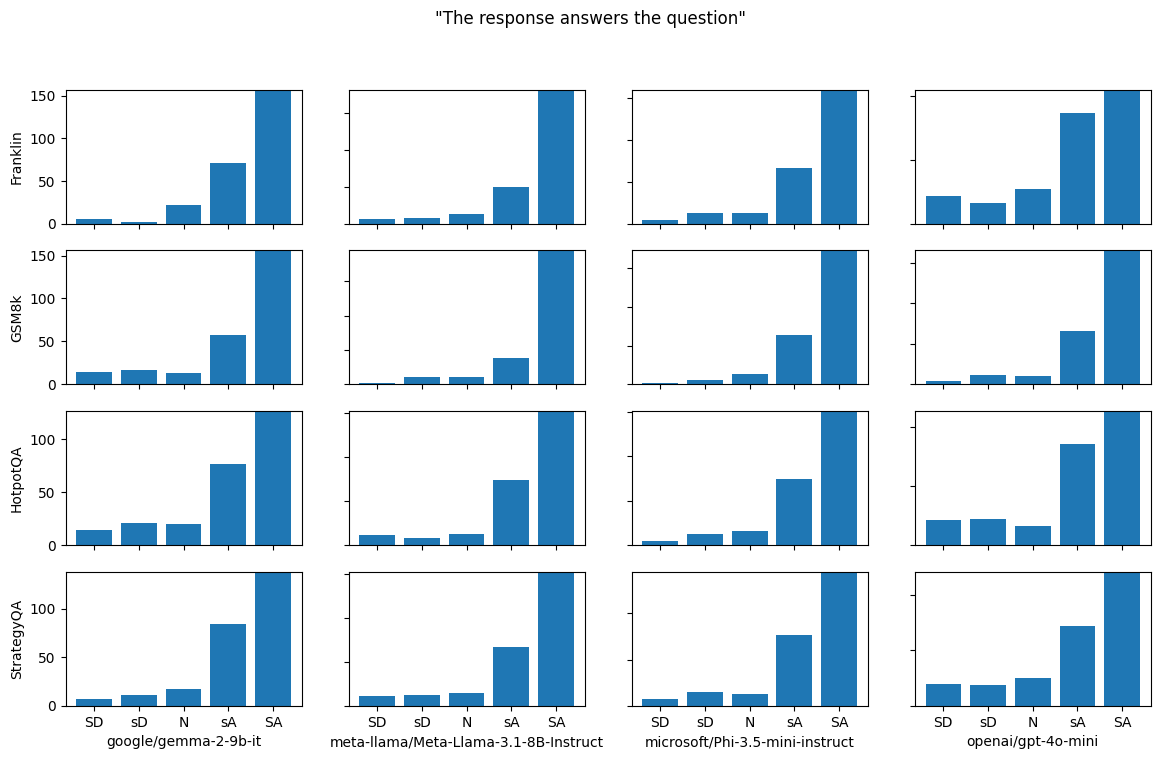

In [956]:
point_scale = 5

# subplots in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(14, 8))
average_ratings = []

for d, dataset in enumerate(datasets):
    for m, model in enumerate(models):
        values = sat[(dataset, model)].to_numpy()
        # remove nan values from numpy array
        values = values[~pd.isna(values)]
        # frequency of each value
        counts = pd.Series(values).value_counts()
        # add to average ratings
        average_ratings.append(
            {
                'dataset': dataset,
                'model': model,
                'average': values.mean(),
                'std': values.std(),
                'sem': pd.Series(values).sem(),
            }
        )
        # plot the frequency of each value
        axs[d, m].bar(counts.index, counts.values)
        # set x axis to i2t for each value
        axs[d, m].set_xticks(range(1, point_scale + 1))
        axs[d, m].set_xticklabels([i2t(i, point_scale) for i in range(1, point_scale + 1)], ha='center')
        # set y axis to 0-max frequency
        axs[d, m].set_ylim(0, counts.max())
        # set x axis label to the model
        axs[d, m].set_xlabel(model)
        # set y axis label to the dataset
        axs[d, m].set_ylabel(dataset)

# only show bottom x axis labels
for ax in axs.flat:
    ax.label_outer()

# set the title of the entire plot
fig.suptitle('"The response answers the question"')

print(pd.DataFrame(average_ratings))
plt.show()

In [957]:
dataset = 'Franklin'
# dataset = 'GSM8k'
# dataset = 'HotpotQA'
# dataset = 'StrategyQA'
model = 'google/gemma-2-9b-it'
# model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
# model = 'microsoft/Phi-3.5-mini-instruct'
model = 'openai/gpt-4o-mini'


In [958]:
print(f'{dataset} - {model}')
sat[(dataset, model)]

Franklin - openai/gpt-4o-mini


,0869444c-aa4b-492a-8a13-985f6d6720b5_1,d72fa515-c0f1-41ae-a792-a96409c69308_1,0376540a-e2f3-4245-8f06-2ac14a692010_1,cdf1283c-f705-45c4-af93-3cd42956dec6_1,5eeb2ad1-df04-4feb-b414-9746cc99f78c_1,0be5ff45-2379-4bfd-81ee-7d2eb41ae7a1_1,e1681ec9-220e-401a-b534-920319d8d157_1,43dd9c34-ef32-4a0f-85f0-8e07ad354dd0_1,65762c75-e21d-49dd-bbbb-77a368b1b5d2_1,32b1f7dc-db5a-404f-babd-b0b93b77eabb_1,...,05421006-2567-4b5a-b278-707508b7437b_1,3dd60711-96de-4923-a71b-edce7031651b_1,26c6302a-481f-4a76-96d9-68ad30a9ca58_1,c8a7f9ce-ff34-4264-922c-88103360c995_1,191ffea9-0384-488e-bdbf-6df846059869_1,27717108-e566-4026-b387-b2e0bdbde84b_1,950b7187-5588-4b0f-a1e1-cdacd1ba3150_1,2fea27be-9ba3-45b2-8288-1213039568be_1,7b419f29-8cc7-4c1d-8bd9-c273b4dd1182_1,58bb25a0-f690-41e9-a781-a92f315d9da4_1
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
5ebd30bca8d08203a6e2334f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66f88d8c5fa10159db0db5c8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f4cbdf9f599118d27c21442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669129db4e9424079e8fb66b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6648c2b185cc799f4856c1b4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6644b2aa02acf5d3b7fc8188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66a18abd1f0ca227f65962bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6435816b3f5be1197802bcd5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
